# работа с *low-level TensorFlow API*

In [2]:
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


## $ z=w*x+b$

In [3]:
## создание графа
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32, shape=(None), name='x')
    w = tf.Variable(2.0, name='weight')
    b = tf.Variable(0.7, name='bias')
    z = w*x + b
    init = tf.global_variables_initializer()

## создание сессии графа G
with tf.Session(graph=g) as sess:
    ## инициализация w и b:
    sess.run(init)
    ## оценка z:
    for t in [1.0, 0.6, -1.8]:
        print('x=%4.1f ~> z=%4.1f'%(t, sess.run(z, feed_dict={x:t})))

x= 1.0 ~~> z= 2.7
x= 0.6 ~~> z= 1.9
x=-1.8 ~~> z=-2.9


In [4]:
with tf.Session(graph=g) as sess:
    sess.run(init)
    print('Можно передавть векторы (x.shape=?)\n z= ',
          sess.run(z, feed_dict={x:[1., 2., 3.]}))

Можно передавть векторы (x.shape=?)
 z=  [2.7 4.7 6.7]


## tf+array

In [5]:
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32, 
                       shape=(None, 2, 3),
                       name='input_x')
    x2 = tf.reshape(x, shape=(-1, 6),name='x2')
    # вычисление суммы по каждому столбцу
    xsum = tf.reduce_sum(x2, axis=0, name='col_sum')
    # вычисление среднего по каждому столбцу
    xmean = tf.reduce_mean(x2, axis=0, name='col_mean')

    
with tf.Session(graph=g) as sess:
    x_array = np.arange(18).reshape(3, 2, 3)
    print('Размер входной формы: ', x_array.shape)
    print('Входная форма:\n', x_array)
    print('\n После изменения формы: \n', 
          sess.run(x2, feed_dict={x:x_array}))
    print('\n Сумма по столбцам: \n', 
          sess.run(xsum, feed_dict={x:x_array}))
    print('\n Среднее по столбцам: \n', 
          sess.run(xmean, feed_dict={x:x_array}))

Размер входной формы:  (3, 2, 3)
Входная форма:
 [[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]

 [[12 13 14]
  [15 16 17]]]

 После изменения формы: 
 [[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]]

 Сумма по столбцам: 
 [18. 21. 24. 27. 30. 33.]

 Среднее по столбцам: 
 [ 6.  7.  8.  9. 10. 11.]


# TF Linear Regression

In [6]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                    2.0, 5.0, 6.3, 
                    6.6, 7.4, 8.0, 9.0])

In [7]:
class TFLineReg(object):
    def __init__(self, x_dim, learning_rate=0.01, random_seed=None):
        self.x_dim = x_dim
        self.learning_rate = learning_rate
        self.g = tf.Graph()
        ## построение модели 
        with self.g.as_default():
            ## установка graph-level random-seed
            tf.set_random_seed(random_seed)

            self.build()
            ## создание инициализатора
            self.init_op = tf.global_variables_initializer()
            
    def build(self):
        ## определение заполнителей (placeholders) для входов
        self.X = tf.placeholder(dtype=tf.float32,
                                shape=(None, self.x_dim),
                                name='x_input')
        self.y = tf.placeholder(dtype=tf.float32, 
                                shape=(None),
                                name='y_input')
        print(self.X)
        print(self.y)
        # определение матрицы весов и векетора смещений
        w = tf.Variable(tf.zeros(shape=(1)), name= 'weight')
        b = tf.Variable(tf.zeros(shape=(1)), name= 'bias')
        print(w)
        print(b)
        
        self.z_net = tf.squeeze(w*self.X + b, name='z_net')
        print(self.z_net)
        
        sqr_errors = tf.square(self.y - self.z_net,  name='sqr_errors')
        print(sqr_errors)
        
        self.mean_cost = tf.reduce_mean(sqr_errors, name='mean_cost')
        
        optimizer = tf.train.GradientDescentOptimizer(
                    learning_rate=self.learning_rate, 
                    name='GradientDescent')
        self.optimizer = optimizer.minimize(self.mean_cost)

In [8]:
# печатаются 6 узлов графа (имена и форма)
lrmodel = TFLineReg(x_dim=X_train.shape[1], learning_rate=0.01)

Tensor("x_input:0", shape=(?, 1), dtype=float32)
Tensor("y_input:0", dtype=float32)
<tf.Variable 'weight:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'bias:0' shape=(1,) dtype=float32_ref>
Tensor("z_net:0", dtype=float32)
Tensor("sqr_errors:0", dtype=float32)


In [9]:
def train_linreg(sess, model, X_train, y_train, num_epochs=10):
    ## Инициализация всех переменных: W & b
    sess.run(model.init_op)
    
    training_costs = []
    for i in range(num_epochs):
        _, cost = sess.run([model.optimizer, model.mean_cost], 
                           feed_dict={model.X:X_train, model.y:y_train})
        training_costs.append(cost)
        
    return training_costs

In [10]:
sess = tf.Session(graph=lrmodel.g)
training_costs = train_linreg(sess, lrmodel, X_train, y_train)

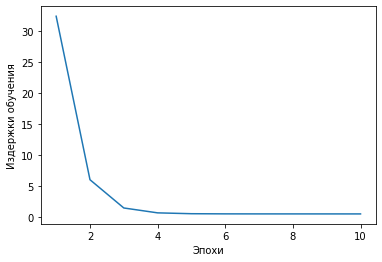

In [11]:
plt.plot(range(1,len(training_costs) + 1), training_costs)
plt.xlabel('Эпохи')
plt.ylabel('Издержки обучения');

In [12]:
def predict_linreg(sess, model, X_test):
    y_pred = sess.run(model.z_net,  feed_dict={model.X:X_test})
    return y_pred

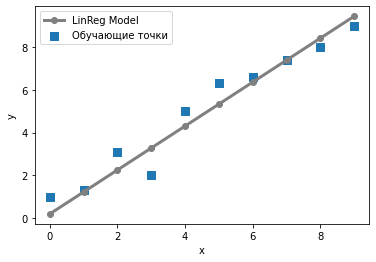

In [13]:
plt.scatter(X_train, y_train, marker='s', s=50,label='Обучающие точки')

plt.plot(range(X_train.shape[0]), predict_linreg(sess, lrmodel, X_train),
         color='gray', marker='o', markersize=6, linewidth=3, label='LinReg Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();